In [1]:
import os
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any, Optional
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

import openai
import os
import time
import pandas as pd

from ragas.llms import LangchainLLMWrapper
from langchain_deepseek import ChatDeepSeek
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import AnswerAccuracy
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

#### Loading the TriviaQA sample

In [2]:
import os

os.environ["HF_DATASETS_CACHE"] = "/scratch-local/yhuang/huggingface_cache"
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [3]:
TriviaQA_sample = load_dataset(
    "json",
    data_files="trivia_sample_raw.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

Generating train split: 0 examples [00:00, ? examples/s]

## Using the off-the-shelf Qwen3-4B for classification

#### Prompt setting

In [4]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

task_FS_UND = """
Analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}
"""

#### Loading the model

In [5]:
Qwen3_4B = "Qwen/Qwen3-4B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_4B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_4B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

cuda


#### Helper functions

In [6]:
def batch_generate_responses_qwen3(prompts, system_prompt=system_prompt,
                             temperature=0.7, max_new_tokens=32768, batch_size=5,
                             enable_thinking=True, parse_thinking=True):
    """
    批量生成Qwen 3模型的回复

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        max_new_tokens: 生成的最大token数，默认为512
        batch_size: 每批处理的提示词数量，默认为4
        enable_thinking: 是否启用思考模式，默认为True
        parse_thinking: 是否解析思考内容，默认为True

    返回:
        如果parse_thinking=True，返回(思考内容列表, 回复内容列表)的元组
        如果parse_thinking=False，返回回复列表
    """

    responses = []
    thinking_contents = [] if parse_thinking else None

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_texts = []

        # 为每个提示词准备输入文本
        for prompt in batch_prompts:
            if system_prompt:
                messages = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ]
            else:
                messages = [
                    {"role": "user", "content": prompt}
                ]

            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=enable_thinking  # 启用思考模式
            )
            batch_texts.append(text)

        # 批量编码输入
        model_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # 生成回复
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                repetition_penalty=1.2
            )

        # 处理生成的回复
        batch_responses = []
        batch_thinking = [] if parse_thinking else None

        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids):
            response_ids = output_ids[len(input_ids):].tolist()

            if parse_thinking and enable_thinking:
                # 解析思考内容
                try:
                    # 寻找</think>对应的token ID (151668)
                    index = len(response_ids) - response_ids[::-1].index(151668)
                except ValueError:
                    index = 0

                thinking_content = tokenizer.decode(response_ids[:index], skip_special_tokens=True).strip("\n")
                content = tokenizer.decode(response_ids[index:], skip_special_tokens=True).strip("\n")

                batch_thinking.append(thinking_content)
                batch_responses.append(content)
            else:
                # 不解析思考内容，直接返回完整回复
                response = tokenizer.decode(response_ids, skip_special_tokens=True)
                batch_responses.append(response)

        responses.extend(batch_responses)
        if parse_thinking:
            thinking_contents.extend(batch_thinking)

    if parse_thinking:
        return thinking_contents, responses
    else:
        return responses

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments



def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_qwen3(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[0]
  df['model_response'] = output[1]
  to_process = output[1]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['question']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts


def add_columns_to_dataset(dataset, columns_dict, inplace=False):
    """
    Adding multiple columns to a HuggingFace Dataset

    params：
        dataset (Dataset): The original dataset
        columns_dict (dict): The new columns organized in a dict, keys are column names, value lists should be of the same length with Dataset
        inplace (bool): whether to change the orignial Dataset or create a new copy

    return：
        Dataset: The new dataset with new columns added
    """
    if not inplace:
        dataset = deepcopy(dataset)

    for column_name, values in columns_dict.items():
        if len(values) != len(dataset):
            raise ValueError(f"Length mismatch：'{column_name}' The column length is {len(values)}, but the dataset has {len(dataset)} samples.")
        dataset = dataset.add_column(column_name, values)

    return dataset

def merge_df_into_dataset_by_order(dataset, df: pd.DataFrame, 
                                   columns=None, prefix: str="", inplace=False):
    """
    将 DataFrame 的指定列，按行顺序写回 HuggingFace Dataset。
    要求：df 与 dataset 行顺序一致、长度相同。
    """
    if columns is None:
        # 默认把 df 的所有列都写回（可用 prefix 避免重名）
        columns = list(df.columns)

    if len(df) != len(dataset):
        raise ValueError(f"Length mismatch: df={len(df)} vs dataset={len(dataset)}.")

    # 将 NaN -> None，并转成 Python 原生类型列表
    columns_dict = {}
    for col in columns:
        series = df[col]
        # 统一把 NaN 转成 None
        values = series.where(series.notna(), None).tolist()
        columns_dict[f"{prefix}{col}"] = values

    # 你已有的工具函数
    updated_dataset = add_columns_to_dataset(dataset, columns_dict, inplace=inplace)
    return updated_dataset

#### Direct classification with Qwen3-4B

In [7]:
df_TriviaQA_sample = pd.read_json("trivia_sample_raw.jsonl", lines=True)
test_prompts = prepare_test_prompts(df_TriviaQA_sample, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1000
Generation complete: 1000 prompts
Average prompt length: 381 bytes (~95 tokens)

Analyze the following input user query:

{"query": "What general name is given to a rotating star which emits a regular beat of radiation?"}

Please provide your analysis in the following JSON format:

{"query": "What general name is given to a rotating star which emits a regular beat of radiation?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [8]:
test_df = run_experiment(test_prompts, df_TriviaQA_sample)
test_df.to_csv('BASELINE_TriviaQA_classification_all.csv')
test_df

100%|██████████| 200/200 [1:57:28<00:00, 35.24s/it]  


,question,id,normalized_aliases,thinking,model_response,model_pred
0,What general name is given to a rotating star ...,sfq_178,"[yukon optics, beltex optics, pulsar]","<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""What general name is given to a...",fully specified
1,"""Which Gilbert and Sullivan operetta is sub ti...",sfq_11822,"[ruddigore, ruddigore witch s curse, rudigore,...","<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""Which Gilbert and Sullivan oper...",underspecified
2,Which English cricketer had figures for bowlin...,sfq_17752,"[james laker, jim laker]","<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""Which English cricketer had fig...",fully specified
3,Wolf Mankowitz wrote the 1953 novel ‘A Kid For...,qb_2689,"[farthings, farthing, farthing disambiguation,...","<think>\nOkay, let's take a look at this user ...","{\n ""query"": ""Wolf Mankowitz wrote the 1953 n...",underspecified
4,Who is the patron saint of dancers?,sfq_6199,"[saint crescentia, saint vitus, vitus, s vito,...","<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who is the patron saint of danc...",underspecified
...,...,...,...,...,...,...
995,"In what French region would you find Omaha, Ju...",jp_159,"[normandy france, normandy, normandy region]","<think>\nOkay, let's see. The user is asking a...","{\n ""query"": ""In what French region would you...",fully specified
996,Who famously had children with both Julius Cae...,jp_2596,"[keeuopatrai, queen cleopatra vii, queen cleop...","<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Who famously had children with ...",fully specified
997,Which band released the albums Sheer Heart Att...,sfq_20578,"[quene, queen disambiguation, queen album, que...","<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Which band released the albums ...",fully specified
998,In which 1984 film did Tom Hanks fall in love ...,qf_2678,"[splash american band, splash band, splash alb...","<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""In which 1984 film did Tom Ha...",fully specified


In [9]:
annotated_dataset = merge_df_into_dataset_by_order(
    TriviaQA_sample, 
    test_df, 
    columns=["thinking", "model_response", "model_pred"],
    prefix="qwen3_",
    inplace=False
)

In [10]:
# Create the UND subset
underspecified_set = annotated_dataset.filter(
    lambda x: x["qwen3_model_pred"].strip().lower() == "underspecified"
)

# Create the FS subset
fully_specified_set = annotated_dataset.filter(
    lambda x: x["qwen3_model_pred"].strip().lower() == "fully specified"
)

# The size of subsets
print(f"Underspecified samples: {len(underspecified_set)}")
print(f"Fully specified samples: {len(fully_specified_set)}")

annotated_dataset.to_json("BASELINE_classified_TriviaQA_sample_all.jsonl", orient="records", lines=True)
underspecified_set.to_json("BASELINE_classified_TriviaQA_sample_UND.jsonl", orient="records", lines=True)
fully_specified_set.to_json("BASELINE_classified_TriviaQA_sample_FS.jsonl", orient="records", lines=True)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Underspecified samples: 159
Fully specified samples: 841


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2487696

# QA implementations

In [2]:
underspecified_set = load_dataset(
    "json",
    data_files="BASELINE_classified_TriviaQA_sample_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
    data_files="BASELINE_classified_TriviaQA_sample_FS.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Loading GPT for short QA

In [ ]:
from openai import OpenAI

client = OpenAI() # Delete when sharing

In [4]:
def ask_short_answer(question, client, model="gpt-4o-2024-11-20", temperature=0, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question with concise responses. "
        "Return answers as a list of strings. If there's only one answer, return a single-item list. "
        "Each answer should be brief and direct."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            content = response.choices[0].message.content
            if content.startswith("["):
                return eval(content)
            else:
                return [content.strip()]
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
    return ["[Error]: Max retries exceeded"]

In [5]:
def run_batch_shortQA_api(batch, client, **kwargs):
    short_answers = []
    for q in batch["question"]:
        try:
            answer = ask_short_answer(q, client=client, **kwargs)
            short_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

In [6]:
def batch_QA_with_progress(dataset, batch_fn, output_key, batch_size=5, fill_value="error", **batch_fn_kwargs):
    all_outputs = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch, **batch_fn_kwargs)
            if output_key not in output:
                raise ValueError(f"Missing key '{output_key}' in batch result")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    if len(all_outputs) != len(dataset):
        print(f"[Warning] Output length mismatch, auto-filling")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

## Implementations

In [7]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 32/32 [01:58<00:00,  3.70s/it]


In [8]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 169/169 [06:46<00:00,  2.41s/it]


In [9]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])

qa_underspecified.to_json("BASELINE_TriviaQA_UND_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

571169

In [10]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])

qa_fully_specified.to_json("BASELINE_TriviaQA_FS_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2520623

In [11]:
df = pd.read_json("BASELINE_TriviaQA_UND_qa_gpt.jsonl", lines=True)
df.to_csv('BASELINE_TriviaQA_UND_qa_gpt.csv')

df = pd.read_json("BASELINE_TriviaQA_FS_qa_gpt.jsonl", lines=True)
df.to_csv('BASELINE_TriviaQA_FS_qa_gpt.csv')

# Evaluations

In [12]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="BASELINE_TriviaQA_UND_qa_gpt.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="BASELINE_TriviaQA_FS_qa_gpt.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Squad EM + F1

In [13]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="BASELINE_TriviaQA_FS_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["normalized_aliases"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 81.81
F1 Score: 88.68


In [14]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="BASELINE_TriviaQA_UND_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["normalized_aliases"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 64.78
F1 Score: 75.75


In [15]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="normalized_aliases"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [16]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("BASELINE_TriviaQA_UND_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

573938

In [17]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("BASELINE_TriviaQA_FS_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2534633

In [18]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 64.78
UND F1 Score (avg): 75.77
FS Exact Match (avg): 81.93
FS F1 Score (avg): 88.77
F1: t=4.163, p=0.0000
EM: t=4.260, p=0.0000


In [19]:
UND_full = load_dataset(
    "json",
    data_files="BASELINE_TriviaQA_UND_qa_gpt_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="BASELINE_TriviaQA_FS_qa_gpt_with_squad_scores.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
df = pd.read_json("BASELINE_TriviaQA_UND_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('BASELINE_TriviaQA_UND_qa_gpt_with_squad_scores.csv')

df = pd.read_json("BASELINE_TriviaQA_FS_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('BASELINE_TriviaQA_FS_qa_gpt_with_squad_scores.csv')

In [3]:
print(f'gpt_4o TriviaQA NQ UND qa EM SD: {np.std(UND_full["em"])}')
print(f'gpt_4o TriviaQA NQ FS qa EM SD: {np.std(FS_full["em"])}')
print(f'gpt_4o TriviaQA NQ UND qa F1 SD: {np.std(UND_full["f1"])}')
print(f'gpt_4o TriviaQA NQ FS qa F1 SD: {np.std(FS_full["f1"])}')

gpt_4o TriviaQA NQ UND qa EM SD: 0.46504199449411593
gpt_4o TriviaQA NQ FS qa EM SD: 0.40458189638495196
gpt_4o TriviaQA NQ UND qa F1 SD: 0.3622724129981127
gpt_4o TriviaQA NQ FS qa F1 SD: 0.2936539771078576


In [4]:
def welch_df(n1, sd1, n2, sd2):
    var1 = sd1**2
    var2 = sd2**2
    numerator = (var1/n1 + var2/n2)**2
    denominator = ((var1/n1)**2)/(n1 - 1) + ((var2/n2)**2)/(n2 - 1)
    return numerator / denominator

In [5]:
welch_df(98, np.std(UND_full["em"]), 902, np.std(FS_full["em"]))

113.52656977914847

In [6]:
welch_df(98, np.std(UND_full["f1"]), 902, np.std(FS_full["f1"]))

111.28240242834372

## Visualization

In [41]:
print("FS F1:", set(FS_f1_list))
print("UND F1:", min(UND_f1_list), max(UND_f1_list))

FS F1: {0.5714285714285715, 1.0, 0.6666666666666666, 0.0, 0.5, 0.3076923076923077, 0.8, 0.7272727272727272, 0.2222222222222222, 0.75, 0.25, 0.18181818181818182, 0.1935483870967742, 0.3636363636363636, 0.6, 0.5454545454545454, 0.14285714285714285, 0.15384615384615385, 0.2, 0.23529411764705882, 0.13333333333333333, 0.19999999999999998, 0.7777777777777778, 0.2857142857142857, 0.28571428571428575, 0.8571428571428571, 0.33333333333333337, 0.8461538461538461, 0.4, 0.888888888888889, 0.9333333333333333, 0.7499999999999999}
UND F1: 0.0 1.0


In [42]:
import numpy as np
q1 = np.percentile(FS_f1_list, 25)
q2 = np.percentile(FS_f1_list, 50)
q3 = np.percentile(FS_f1_list, 75)
print(f"Q1={q1:.2f}, Median={q2:.2f}, Q3={q3:.2f}")

Q1=1.00, Median=1.00, Q3=1.00


In [21]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
plt.title("gpt-4o-2024-11-20 F1 Score Distribution by Subset_BASELINE")
plt.tight_layout()
plt.savefig("TriviaQA_f1_boxplot_gpt_BASELINE.png")
plt.close()

/scratch-local/yhuang.14606769/ipykernel_3805573/3359582170.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)


In [22]:
df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("gpt-4o-2024-11-20 Exact Match Rate by Subset_BASELINE (± CI)")
plt.tight_layout()
plt.savefig("TriviaQA_em_barplot_gpt_BASELINE.png",dpi=300)
plt.close()

/scratch-local/yhuang.14606769/ipykernel_3805573/483144419.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.14606769/ipykernel_3805573/483144419.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


In [23]:
# 设置学术风格
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(6.5, 4.5))

# Violin plot 只显示分布，不显示 quartile
sns.violinplot(
    x="Subset", y="F1", data=df_f1,
    palette="Set2", inner=None, cut=0
)

# 叠加 boxplot 显示中位数和 IQR，透明一点避免遮住 violin
sns.boxplot(
    x="Subset", y="F1", data=df_f1,
    width=0.2, showcaps=True, boxprops={'facecolor':'white', 'zorder':2},
    whiskerprops={'linewidth':1.5}, medianprops={'color':'black', 'linewidth':2},
    showfliers=False
)

# 叠加 stripplot 显示原始点（可选）
sns.stripplot(
    x="Subset", y="F1", data=df_f1,
    color='black', size=2.5, jitter=True, alpha=0.4
)

plt.ylim(-0.05, 1.05)
plt.title("gpt-4o-2024-11-20 F1 Score Distribution by Subset_BASELINE", fontsize=14)
plt.xlabel("")
plt.ylabel("F1 Score", fontsize=12)

plt.tight_layout()
plt.savefig("fig_gpt4o_f1_by_subset_BASELINE.png", dpi=300) 
plt.show()

/scratch-local/yhuang.14606769/ipykernel_3805573/3277561390.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch-local/yhuang.14606769/ipykernel_3805573/3277561390.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


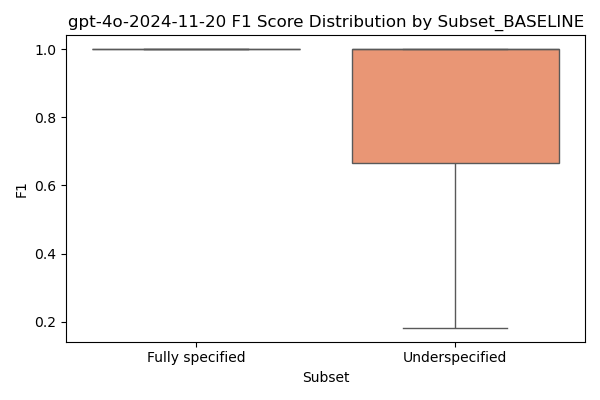

In [24]:
from IPython.display import Image
Image("TriviaQA_f1_boxplot_gpt_BASELINE.png")

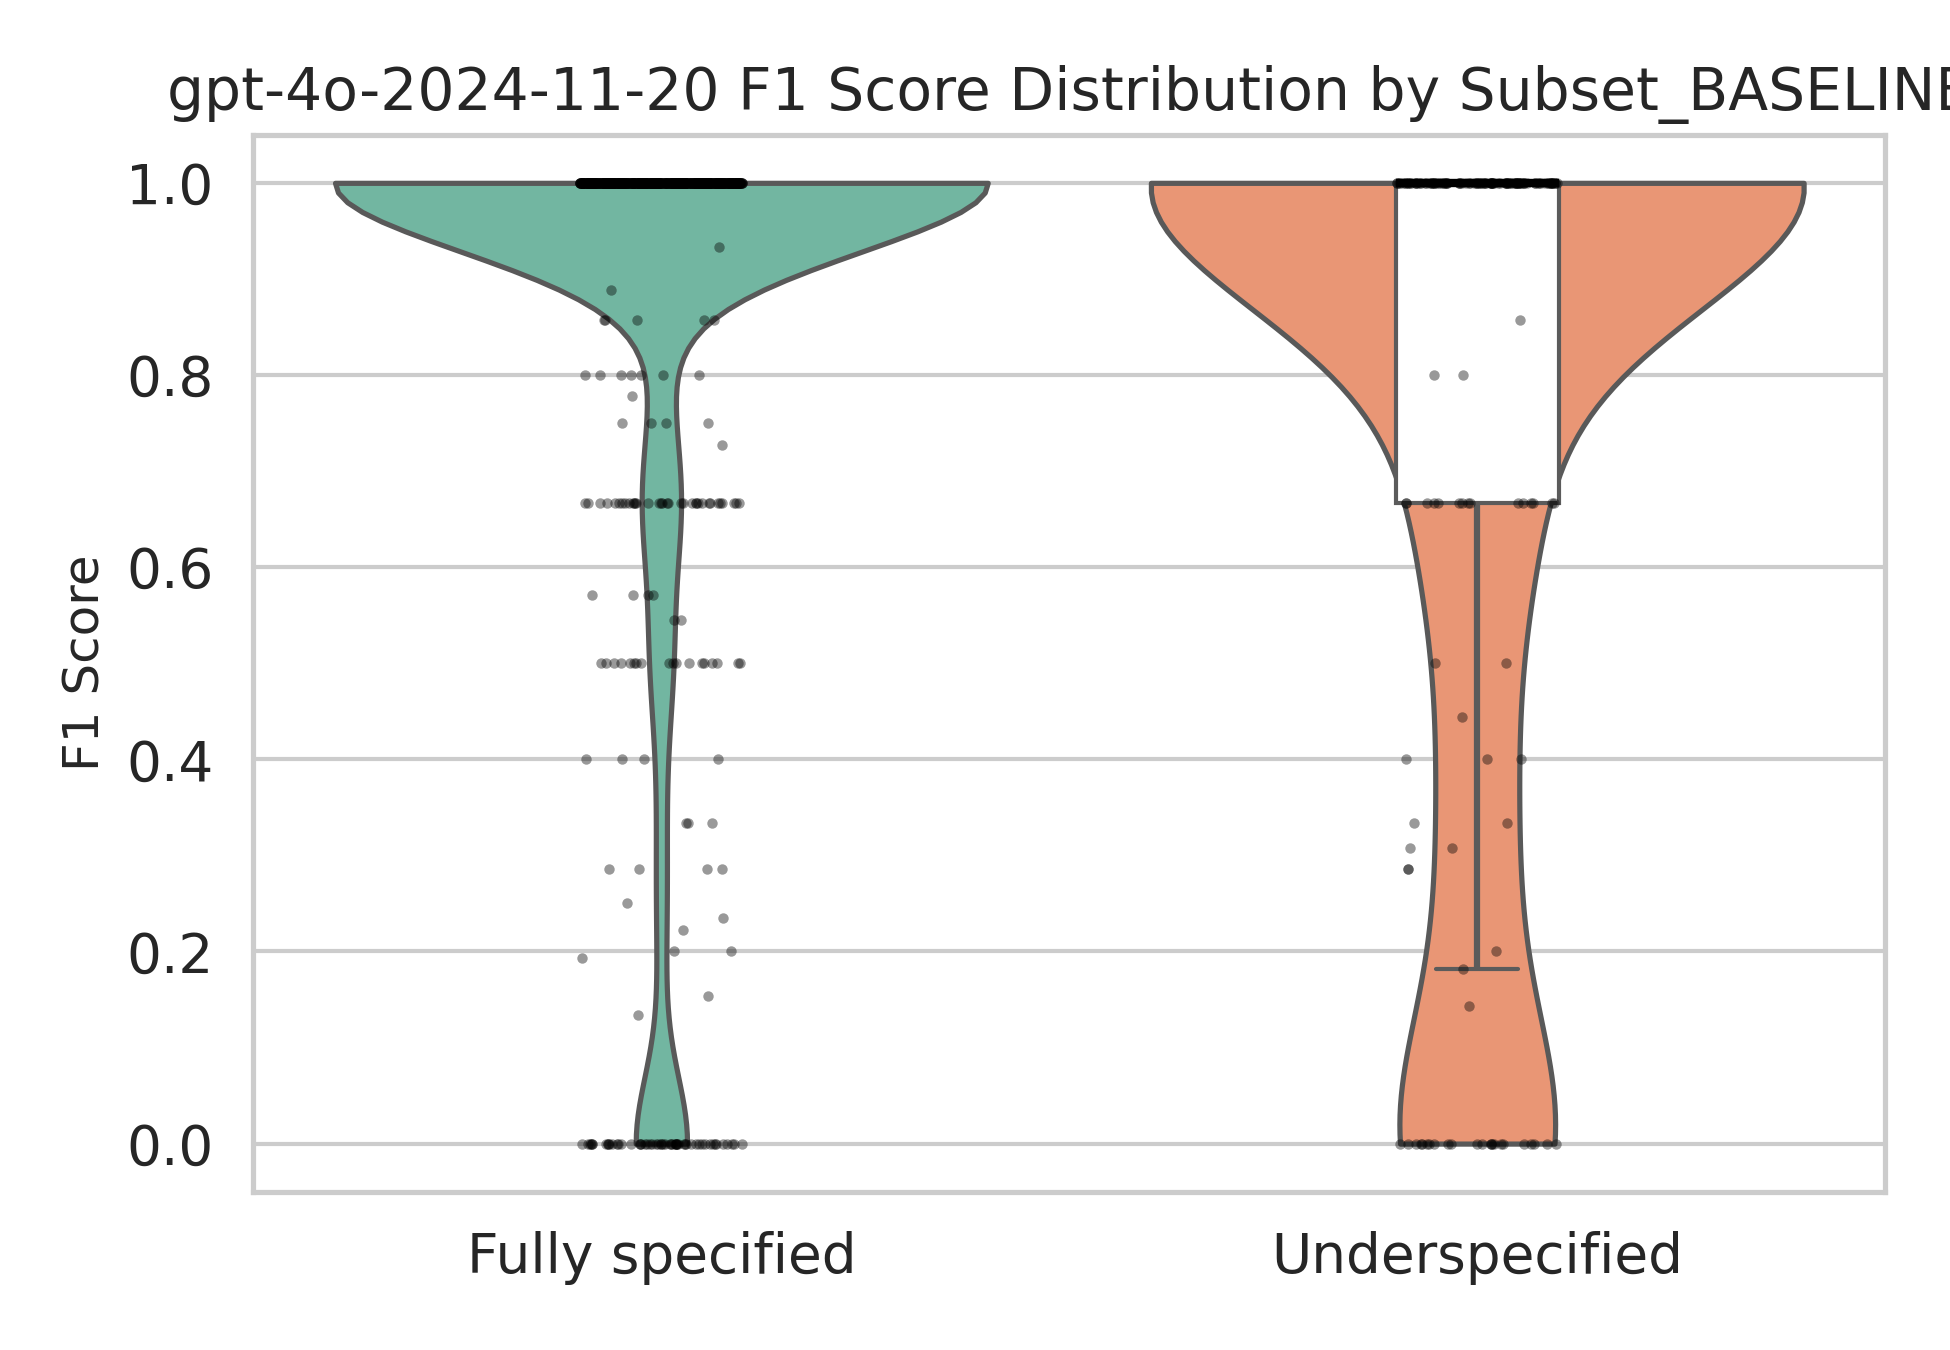

In [25]:
from IPython.display import Image
Image("fig_gpt4o_f1_by_subset_BASELINE.png")

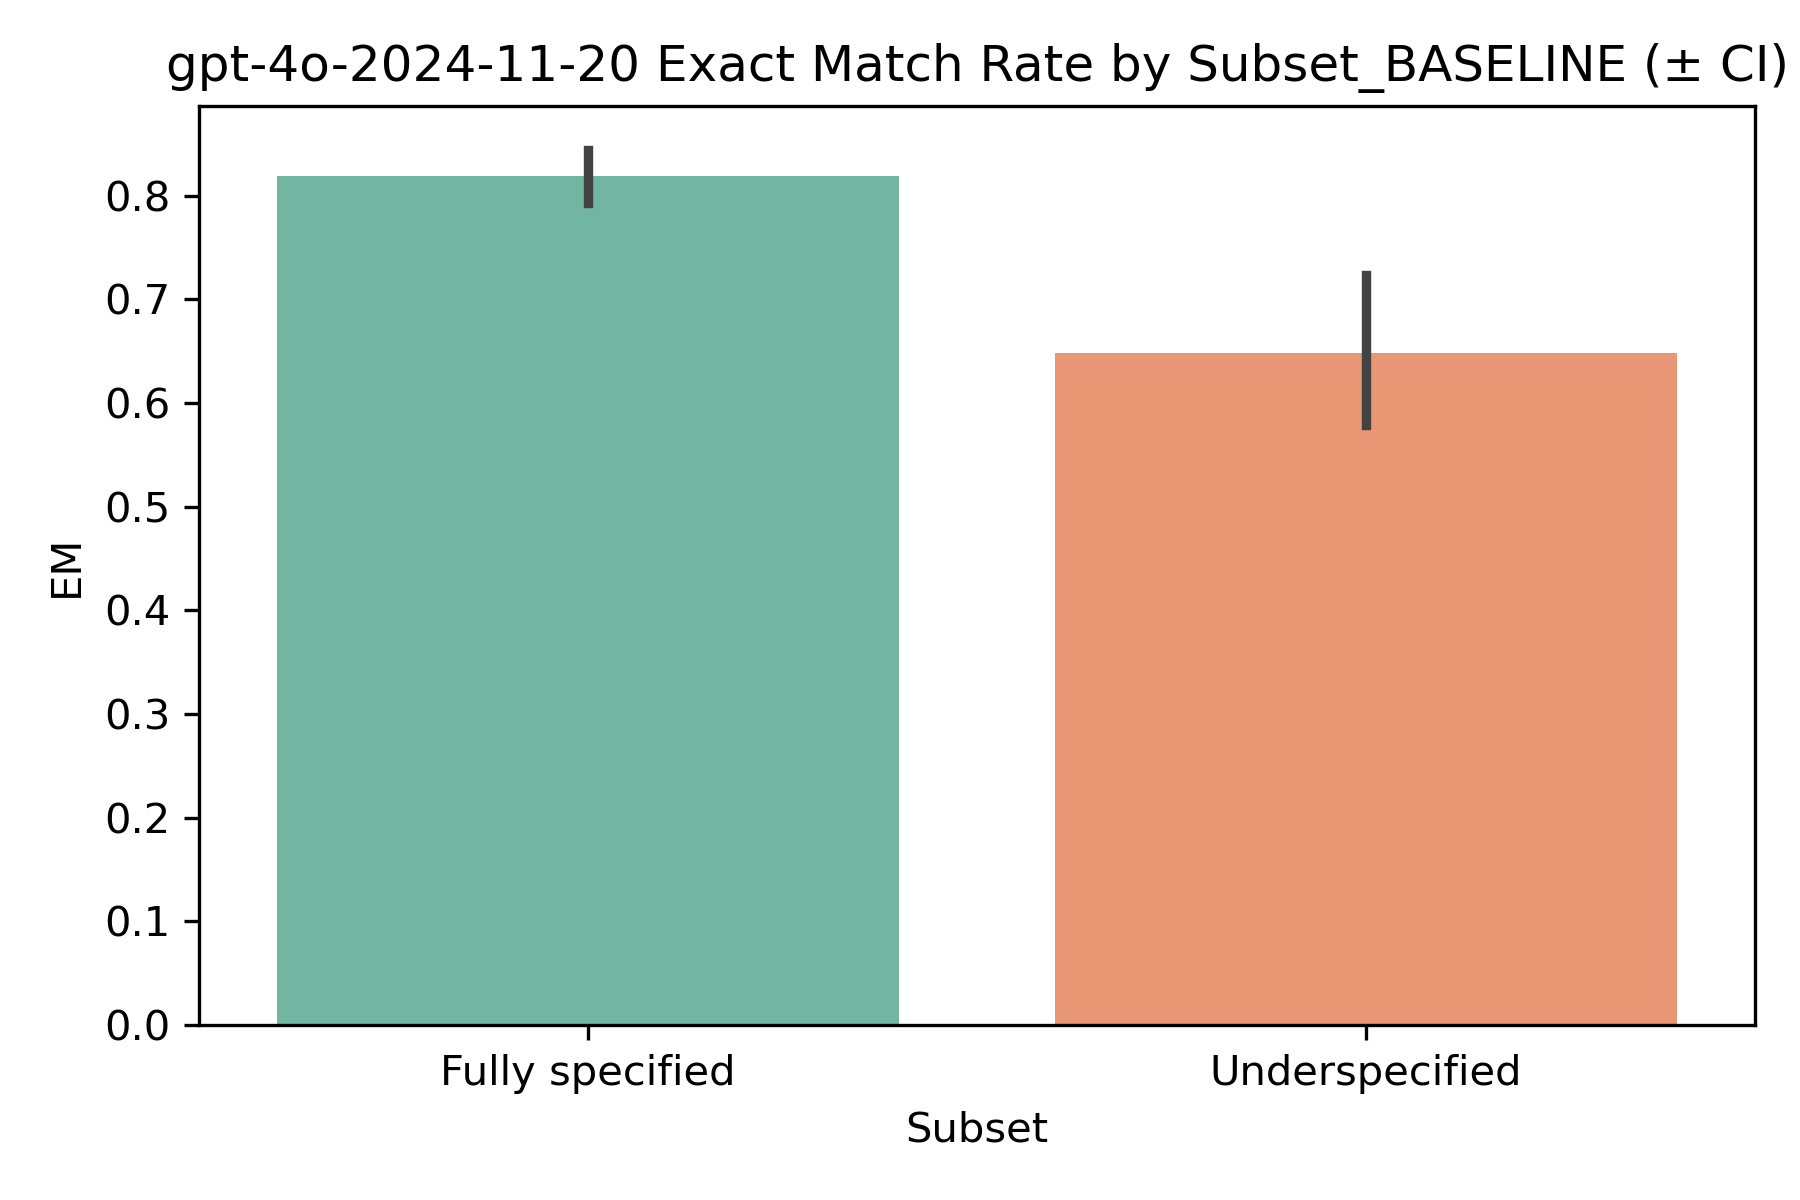

In [26]:
Image("TriviaQA_em_barplot_gpt_BASELINE.png")

### Ragas Evaluation

In [2]:
evaluator_llm = LangchainLLMWrapper(ChatDeepSeek(model="deepseek-chat", verbose=True, temperature=0))

UND_full = load_dataset(
    "json",
    data_files="BASELINE_TriviaQA_UND_qa_gpt_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="BASELINE_TriviaQA_FS_qa_gpt_with_squad_scores.jsonl",
    split="train"
)

In [5]:
async def test_single_sample_optimized(row, evaluator=evaluator_llm):
    """测试单个样本的评分"""
    scorer = AnswerAccuracy(llm=evaluator)
    
    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
    reference_answers = row['normalized_aliases'] if isinstance(row['normalized_aliases'], list) else [row['normalized_aliases']]
    
    print(f"模型答案: {model_answers}")
    print(f"参考答案: {reference_answers}")
    
    max_score = 0.0
    best_combination = None
    
    for i, model_ans in enumerate(model_answers):
        for j, ref_ans in enumerate(reference_answers):
            sample = SingleTurnSample(
                user_input=row['question'],
                response=model_ans,
                reference=ref_ans
            )
            score = await scorer.single_turn_ascore(sample)
            print(f"组合 {i+1}-{j+1}: 分数 = {score}")
            
            if score > max_score:
                max_score = score
                best_combination = (model_ans, ref_ans)
                if score == 1.0:
                    break  # 跳出内层循环
        if max_score == 1.0:
            break  # 跳出外层循环
    
    print(f"最高分数: {max_score}")
    print(f"最佳组合: {best_combination}")
    return max_score

# 测试使用
test_score = await test_single_sample_optimized(UND_full[0])

模型答案: ['Ruddigore']
参考答案: ['ruddigore', 'ruddigore witch s curse', 'rudigore', 'ruddygore']
组合 1-1: 分数 = 1.0
最高分数: 1.0
最佳组合: ('Ruddigore', 'ruddigore')


In [3]:
async def answer_accuracy_optimized(input_dataset, evaluator=evaluator_llm):
    # 在函数开始时创建一次 scorer
    scorer = AnswerAccuracy(llm=evaluator)
    

    score_list = []
        
    for i, row in enumerate(tqdm(input_dataset, desc="Calculating short answer accuracy")):
        try:
            # 短答案评分 - 处理列表情况
            if 'model_short_answer' in row and 'normalized_aliases' in row:
                model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
                reference_answers = row['normalized_aliases'] if isinstance(row['normalized_aliases'], list) else [row['normalized_aliases']]
                    
                # 计算所有组合的分数，取最高分
                max_score = 0.0
                for model_ans in model_answers:
                    for ref_ans in reference_answers:
                        sample = SingleTurnSample(
                                user_input=row['question'],
                                response=model_ans,
                                reference=ref_ans
                            )
                        score = await scorer.single_turn_ascore(sample)
                        max_score = max(max_score, score)
                        if max_score == 1.0:
                            break  # 跳出内层循环
                    if max_score == 1.0:
                        break  # 跳出外层循环
                
                score_list.append(max_score)
            else:
                score_list.append(0.0)
                
        except Exception as e:
            print(f"处理第 {i+1} 个样本时出错: {e}")
            score_list.append(0.0)

    ragas_scored_dataset = input_dataset.add_column("ragas_AA_short", score_list)

    return ragas_scored_dataset

In [9]:
UND_ragas = await answer_accuracy_optimized(UND_full)
UND_ragas.to_csv("TriviaQA_UND_gpt4o_Ragas.csv")

Calculating short answer accuracy: 100%|██████████| 159/159 [1:43:07<00:00, 38.91s/it]   


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

549079

In [4]:
FS_ragas = await answer_accuracy_optimized(FS_full)
FS_ragas.to_csv("TriviaQA_FS_gpt4o_Ragas.csv")

Calculating short answer accuracy: 100%|██████████| 841/841 [6:11:46<00:00, 26.52s/it]    


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2406145

In [6]:
df = pd.read_csv("TriviaQA_UND_gpt4o_Ragas.csv")
UND_ragas_AA = df["ragas_AA_short"].tolist()

#UND_ragas_AA = list(UND_ragas["ragas_AA_short"])
FS_ragas_AA = list(FS_ragas["ragas_AA_short"])

UND_mean_AA = np.mean(UND_ragas_AA)
print(f"UND AA (avg): {UND_mean_AA * 100:.2f}")


FS_mean_AA = np.mean(FS_ragas_AA)
print(f"FS AA (avg): {FS_mean_AA * 100:.2f}")

AA_tstat, AA_pval = ttest_ind(FS_ragas_AA, UND_ragas_AA, equal_var=False)
print(f"AA: t={AA_tstat:.3f}, p={AA_pval:.4f}")

UND AA (avg): 84.28
FS AA (avg): 94.50
AA: t=3.565, p=0.0005
